In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt

<xarray.Dataset> Size: 5kB
Dimensions:      (depth_index: 50, doy: 12)
Coordinates:
  * depth_index  (depth_index) int64 400B 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * doy          (doy) float64 96B 15.0 45.0 75.0 105.0 ... 285.0 315.0 345.0
Data variables:
    temp_c       (depth_index, doy) float64 5kB 18.42 16.97 ... 16.63 16.63

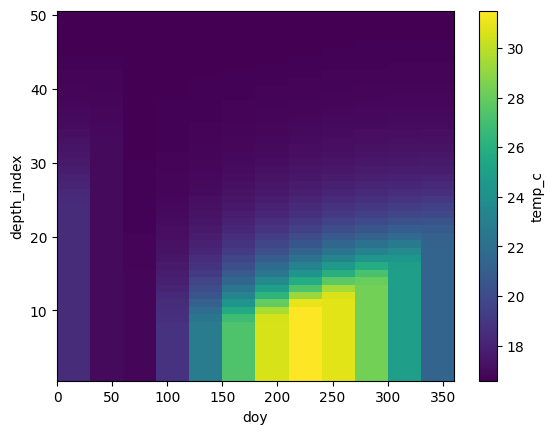

In [3]:
# Load lake data
lakedata =  xr.open_dataset(r'C:\Users\hailey29\OneDrive - UW\Documents\Climate Models\PRYSM-2.0\lake_v2\output\batch\FGL_test_1\results\FGL_control_prof.nc')

# plot lake profile
lakedata['temp_c'].dropna(dim='depth_index').plot()

lakedata

In [ ]:
def clumped_sensor(temp_c, model):
        if model == 'I-CDES90':
            cap47 = 0.0391 * 10**6 / (temp_c + 273.15)**2 + 0.154 # Anderson et al 2021 I-CDES90 ref frame (w/ conversion from Celcius to Kelvin) # not including +/- uncertainties, can add later
        elif model == 'CDES90': 
            cap47 = 1  # will add other functions
        else:
            raise ValueError('Model not recognized')
        
        return cap47 #.to_numpy()

In [ ]:
#Inverse of clumped_sensor functions to return temperature from final clumped value
def clumped_temperature(cap47, model):
        if model == 'I-CDES90':
           temp_c = ((0.0391 * (10**6) / (cap47 - 0.154))**0.5) - 273.15
        elif model == 'CDES90': 
            temp_c = 1  # will add other functions
        else:
            raise ValueError('Model not recognized')
        
        return temp_c #.to_numpy()

Weighting functions 'step' and 'range' in below 2 cells are edited so they aren't calling variables from default_dict, but I'm only using uniform weighting here so it shouldn't have anything to do with the error.

In [7]:
def generate_depth_weights(depth, weight_type):
    """
    Generate a depth-weighting function.

    Args:
        depths (pd.DataFrame): Array or DataFrame column of depth values.
        weight_type (str): Equation type for computing the weighting with depth.

    Returns:
        np.ndarray: Array of weights aligned with the depth values.
    """
    if weight_type == 'uniform':
        weights = [1 if not pd.isna(val) else np.nan for val in depth] # Initialize all weights to 1
        weights = pd.DataFrame(weights, columns=['depth_weights'])
    
    elif weight_type == 'surface':
        weights = [0 if not pd.isna(val) else np.nan for val in depth] # Initialize all weights to 0
        weights[0] = 1  # Assign weight of 1 to the first element
        weights = pd.DataFrame(weights, columns=['depth_weights'])
  
    elif weight_type == 'step':
        depth_min = X  # Set your desired minimum depth
        depth_max = X  # Set your desired maximum depth

        conditions = [
            depth.isna(),
            (depth >= depth_min) & (depth <= depth_max)
        ]
        choices = [np.nan, 1]
        weights = np.select(conditions, choices, default=0)
        weights = pd.DataFrame(weights, index=depth.index, columns=['depth_weights'])

    elif weight_type == 'normal_dist':
        mask = ~depth.isna()
        depth_clean = depth[mask]
        depth_index_mean = round(depth_clean.values.mean(), 2)
        depth_index_std = round(depth_clean.values.std(), 2)
        weights_clean = (1 / (depth_index_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((depth_clean - depth_index_mean) / depth_index_std) ** 2)
        # Normalize the weights so they sum to 1
        weights_clean /= weights_clean.sum()
        weights = np.full_like(depth, np.nan, dtype=np.float64)
        weights[mask] = weights_clean
        weights = pd.DataFrame(weights, index=depth.index, columns=['depth_weights'])
        
    else:
        raise ValueError('Weight type not recognized')
    
    return weights

In [8]:
def generate_time_weights(timesteps, weight_type, selected_months=None): 
    """
    Generate a time-weighting function.

    Args:
        depths (pd.DataFrame): DataFrame column of depth values.
        weight_type (str): Equation type for computing the weighting with doy.
        selected_months (list): List of months to apply the '' weighting function to (e.g. selected_months=['January', 'February']), otherwise 'None'.

    Returns:
        np.ndarray: Array of weights aligned with doy values.
    """
    months = {
        'MAMJ': (60, 182),  # March to June
        'AMJ': (91, 182),  # April to June  
        'AMJJ': (91, 213),  # April to July
        'AMJJASO': (91, 305),  # April to October
        'JJA': (152, 244),  # July to August 
        'ASO': (213, 305),  # August to October
        'January': (0, 32),
        'February': (32, 60),
        'March': (60, 91),
        'April': (91, 121),
        'May': (121, 152),
        'June': (152, 182),
        'July': (182, 213),
        'August': (213, 244),
        'September': (244, 274),
        'October': (274, 305),
        'November': (305, 335),
        'December': (335, 366)
        }
    
    if weight_type == 'uniform':
        weights = [1] * len(timesteps)  # Initialize all weights to 1
        
    elif weight_type == 'range':
        # ... check to see if any selected months don't occur in the months dict
        #     return a message to let the user know (maybe they mis-spelled something)
        missing_keys = [key for key in selected_months if key not in months]
        if missing_keys:
            print(f"Warning: selected month option(s) {missing_keys} is not valid. Please select from {list(months.keys())}")

        # ... filter the months dict for just the selected months
        selected_months_dict = {key: months[key] for key in selected_months if key in months}

        # ... return 1 if the timestep is within one of the ranges, return 0 otherwise
        weights = [1 if any(start <= num <= end for start, end in selected_months_dict.values()) else 0 for num in timesteps]

    elif weight_type == 'normal_dist':
        time_index_mean = round(timesteps.values.tolist().mean(), 2)
        time_index_std = round(timesteps.values.tolist().std(), 2)
        weights = (1 / (time_index_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((timesteps - time_index_mean) / time_index_std) ** 2)
        # Normalize the weights so they sum to 1
        weights /= weights.sum()
        weights = pd.DataFrame(weights, index=timesteps.index, columns=['time_weights'])
    else:
        raise ValueError('Weight type not recognized')
    
    return weights

In [16]:
def clumpedsensor_fromDataset(
    lakedata: xr.Dataset,
    rundict: dict,
    weight_type_depth: str='uniform',
    weight_type_time: str='uniform',
    clumped_model: str='I-CDES90',
    **kwargs
    ) -> xr.Dataset:
    '''
    Read in the lakedata dataset and compute the depth and time 
    weighted temperature and cap47 values

    Parameters
    ----------
    lakedata : xr.Dataset
        dataset produced by the process_ebm_results function
    rundict : dict
        input dictionary to pass to weighting functions for kwargs
    weight_type_* : str
        the type of weighting function to use (for *_depth or *_time)
    clumped_model : str
        name of the calibration model to use for the clumped calculation
    
    Returns 
    -------
    xr.Dataset
        the original dataset with the added weighting, temperature, and cap47 variables
    '''
    timesteps = lakedata['doy'].values.tolist()
    cap47 = []

    for ts in (timesteps) :
        tmpds = lakedata.sel(doy = ts) # pull out this timestep
        tmpdf = tmpds.to_dataframe().reset_index()  # convert it to pandas df

        temp_c = pd.DataFrame(tmpdf['temp_c'])['temp_c']
        depth = pd.DataFrame(tmpdf['depth_index'])['depth_index']
        
        ts_cap47 = clumped_sensor(temp_c, clumped_model)
        ts_cap47 = pd.DataFrame(ts_cap47).copy()
        ts_cap47 = ts_cap47.rename(columns={'temp_c': 'cap47'})
        cap47.append(ts_cap47)
        nan_count = temp_c[::-1].isna().cumprod().sum()
        if nan_count != 0: 
            # then add depth nans to places where there are temperature nans at the bottom of the column
            depth.iloc[-nan_count:] = np.nan 

        depth_weights = generate_depth_weights(depth, weight_type_depth, **rundict)  
        depth_weights = pd.DataFrame(depth_weights.values.flatten())
       
        if ts == timesteps[0]:
            df = pd.DataFrame(tmpdf['doy'].values, columns=['doy'])
            cap47_depth_wtd_mean = (ts_cap47.values * depth_weights).sum() / depth_weights.sum()
            temp_c_depth_wtd_mean = (temp_c * depth_weights).sum() / depth_weights.sum()
            df = df.assign(temp_c_depth_wtd_mean = temp_c_depth_wtd_mean).dropna()
            df = df.assign(cap47_depth_wtd_mean = cap47_depth_wtd_mean).dropna()
        else:
            tdf = pd.DataFrame(tmpdf['doy'].values, columns=['doy'])
            cap47_depth_wtd_mean = (ts_cap47.values * depth_weights).sum() / depth_weights.sum()
            temp_c_depth_wtd_mean = (temp_c * depth_weights).sum() / depth_weights.sum()
            tdf = tdf.assign(temp_c_depth_wtd_mean = temp_c_depth_wtd_mean).dropna()
            tdf = tdf.assign(cap47_depth_wtd_mean = cap47_depth_wtd_mean).dropna()
            df = pd.concat([tdf, df], ignore_index=True)
            df = df.dropna()      

    T47C_depth_wtd_mean = clumped_temperature(df['cap47_depth_wtd_mean'], clumped_model)

    df = df.set_index('doy', drop=True)
    df = df.assign(T47C_depth_wtd_mean = T47C_depth_wtd_mean)
    df = xr.Dataset.from_dataframe(df)
    time_weights = generate_time_weights(timesteps, weight_type_time, **rundict) 
    time_weights = time_weights[::-1]
    df = df.assign(time_weights=(['doy'], time_weights))
    df['cap47_time_wtd_mean'] = (df['cap47_depth_wtd_mean']* df['time_weights']).sum() / df['time_weights'].sum()

    # --- Mean annual lake temperature [MALT] (depth/time weighted) from T47 data to recostruct T47 MAAT
    df['T47C_MALT'] = (df['T47C_depth_wtd_mean'] * df['time_weights']).sum() / df['time_weights'].sum()    
    
    # --- T47 reconstructed MAAT from T47 MALT: MAAT = -0.0318 * T water^2 + 2.195 * T water - 12.607 ; R^2 = 0.96 (Hren & Sheldon 2012 ; [HS12])
    df['T47C_MAAT_HS12'] = (-0.0318 * (df['T47C_MALT']**2)) + (2.195 * df['T47C_MALT']) - 12.607
    
    final_output_init = xr.combine_by_coords([df, lakedata])
 
    # --- actual daily lake surface temperature [LST] from PRYSM lake profile using the 1st depth step (1 meter)
    final_output_init['LST_PRYSM'] = (['doy'], (((pd.DataFrame(final_output_init['temp_c'])).iloc[0]).dropna()))
    
    # --- actual mean annual lake surface temperature [MALST] from PRYSM lake profile to reconstruct actual MAAT
    final_output_init['Actual_MALST_PRYSM'] = (final_output_init['LST_PRYSM'] * df['time_weights']).sum() / df['time_weights'].sum()  
    #
    # --- actual MAAT from MALST: MAAT = -0.0318 * T water^2 + 2.195 * T water - 12.607 ; R^2 = 0.96 (Hren & Sheldon 2012 ; [HS12])
    final_output_init['Actual_MAAT_from_MALST_PRYSM_HS12'] = (-0.0318 * (final_output_init['Actual_MALST_PRYSM'].values**2)) + (2.195 * final_output_init['Actual_MALST_PRYSM'].values) - 12.607
    # ---------------------------------------------------------------------------------------------------

    final_output_init = final_output_init.assign(depth_weights=(['depth_index'], depth_weights.to_numpy().flatten()))
    
    ds_cap47 = xr.Dataset(
    {
        "cap47": (["doy", "depth_index"], np.stack([df[0].values for df in cap47]))
    },
    coords={"doy": final_output_init['doy'].values, "depth_index": final_output_init['depth_index'].values}
    )

    final_output = xr.merge([ds_cap47, final_output_init])
    depth_weights_expanded = np.tile(final_output['depth_weights'], (len(final_output['doy']), 1))
    final_output["depth_weights"] = (['doy', 'depth_index'], depth_weights_expanded)
    final_output = final_output.dropna(dim='depth_index', how='all')
    return final_output

final_output=clumpedsensor_fromDataset(lakedata)

TypeError: clumpedsensor_fromDataset() missing 1 required positional argument: 'rundict'

NameError: name 'final_output' is not defined

In [10]:
def process_lake_data(lakedata):
    timesteps = lakedata['doy'].values.tolist()
    cap47 = []

    for ts in (timesteps) :
        tmpds = lakedata.sel(doy = ts) # pull out this timestep
        tmpdf = tmpds.to_dataframe().reset_index()  # convert it to pandas df

        temp_c = pd.DataFrame(tmpdf['temp_c'])['temp_c']
        depth = pd.DataFrame(tmpdf['depth_index'])['depth_index']
        
        ts_cap47 = clumped_sensor(temp_c, 'I-CDES90')
        ts_cap47 = pd.DataFrame(ts_cap47).copy()
        ts_cap47 = ts_cap47.rename(columns={'temp_c': 'cap47'})
        cap47.append(ts_cap47)
        nan_count = temp_c[::-1].isna().cumprod().sum()
        if nan_count > 0:
            depth.iloc[-nan_count:] = np.nan

        depth_weights = generate_depth_weights(depth, 'uniform')  
        depth_weights = pd.DataFrame(depth_weights.values.flatten())
       
        if ts == timesteps[0]:
            df = pd.DataFrame(tmpdf['doy'].values, columns=['doy'])
            cap47_depth_wtd_mean = (ts_cap47.values * depth_weights).sum() / depth_weights.sum()
            temp_c_depth_wtd_mean = (temp_c * depth_weights).sum() / depth_weights.sum()
            df = df.assign(temp_c_depth_wtd_mean = temp_c_depth_wtd_mean).dropna()
            df = df.assign(cap47_depth_wtd_mean = cap47_depth_wtd_mean).dropna()
        else:
            tdf = pd.DataFrame(tmpdf['doy'].values, columns=['doy'])
            cap47_depth_wtd_mean = (ts_cap47.values * depth_weights).sum() / depth_weights.sum()
            temp_c_depth_wtd_mean = (temp_c * depth_weights).sum() / depth_weights.sum()
            tdf = tdf.assign(temp_c_depth_wtd_mean = temp_c_depth_wtd_mean).dropna()
            tdf = tdf.assign(cap47_depth_wtd_mean = cap47_depth_wtd_mean).dropna()
            df = pd.concat([tdf, df], ignore_index=True)
               

    T47_c_depth_wtd_mean = clumped_temperature(df['cap47_depth_wtd_mean'], 'I-CDES90')

    df = df.set_index('doy', drop=True)
    df = df.assign(T47_c_depth_wtd_mean = T47_c_depth_wtd_mean)
    df = xr.Dataset.from_dataframe(df)
    time_weights = generate_time_weights(timesteps, 'uniform') 
    time_weights = time_weights[::-1]
    df = df.assign(time_weights=(['doy'], time_weights))
    df['cap47_time_wtd_mean'] = (df['cap47_depth_wtd_mean']* df['time_weights']).sum() / df['time_weights'].sum()
    
    #NEW, calculate mean annual lake temperature (depth/time weighted) from T47
    df['T47_c_MALT'] = (df['T47_c_depth_wtd_mean'] * df['time_weights']).sum() / df['time_weights'].sum()    
    
    #NEW, calculate mean annual air temperature from 'T47_c_MALT' above
    df['T47_c_MAAT'] = (-0.0318 * (df['T47_c_MALT']**2)) + (2.195 * df['T47_c_MALT']) - 12.607
    
    final_output_init = xr.combine_by_coords([df, lakedata])
    
    #NEW, find *actual* daily lake surface temperatures using the 1st depth step (1 meter) (to compare to T47 results)
    temp_c_surf = ((pd.DataFrame(final_output_init['temp_c'])).iloc[0]).dropna()
    
    #NEW, assign 'temp_c_surf' to init final output xr dataset
    final_output_init['temp_c_surf'] = (['doy'], temp_c_surf)
    
    #NEW, calculate mean annual lake surface temperature from 'temp_c_surf' above and assign to xr dataset
    final_output_init['temp_c_MALST'] = (temp_c_surf * df['time_weights']).sum() / df['time_weights'].sum()   
    
    #NEW, calculate mean annual air temperature from 'temp_c_MALST' above and assign to xr dataset
    #NOTE: this is where I am getting the error when running in PRYSM, the 'temp_c_MALST' values are accurate but something is going wrong with them in this calculation and the results are wrong (e.g. -9 degrees instead of 15)
    final_output_init['temp_c_surf_MAAT'] = (-0.0318 * (final_output_init['temp_c_MALST'].values**2)) + (2.195 * final_output_init['temp_c_MALST'].values) - 12.607

    final_output_init = final_output_init.assign(depth_weights=(['depth_index'], depth_weights.to_numpy().flatten()))
    ds_cap47 = xr.Dataset(
    {
        "cap47": (["doy", "depth_index"], np.stack([df[0].values for df in cap47]))
    },
    coords={"doy": final_output_init['doy'].values, "depth_index": final_output_init['depth_index'].values}
    )

    final_output_init = xr.merge([ds_cap47, final_output_init])
    depth_weights_expanded = np.tile(final_output_init['depth_weights'], (len(final_output_init['doy']), 1))
    final_output_init["depth_weights"] = (['doy', 'depth_index'], depth_weights_expanded)
    final_output = final_output_init.dropna(dim='depth_index', how='all')
    return final_output

final_output = process_lake_data(lakedata)

final_output

KeyError: 0